In [1]:
from pdf_reader import PDFReader
from preprocessor import Preprocessor
from vectorizer import Vectorizer
from visualizer import DocumentVisualizer
from rf_model import RFModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from feature_extractor import Extractor
import os
import numpy as np

In [2]:
# Load Word2Vec model
vectorizer = Vectorizer("word2Vec_models/cbow_s1000.txt")

In [3]:
pdf_reader = PDFReader()
preprocessor = Preprocessor()
document_visualizer = DocumentVisualizer()
feature_extractor = Extractor(vectorizer, pdf_reader, preprocessor)

# Create BoW representation of documents
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
lda = LatentDirichletAllocation(n_components=2, random_state=42)

rf_clf = RFModel()

In [4]:
# Process labeled data
train_doc_names = [filename for filename in os.listdir('documents/') if filename.endswith('.pdf')]
file_paths_train = [os.path.join('documents', filename) for filename in os.listdir('documents') if filename.endswith('.pdf')]
X_combined = feature_extractor.extract_features(file_paths_train)

# Define labels for the documents
y = []
for filename in os.listdir('documents/'):
    if filename.endswith('.pdf'):
        if filename.startswith("risk"):
            label = 0  # Risk Report
        elif filename.startswith("privacy"):
            label = 1  # Privacy Policy
        y.append(label)

# Transform documents to a matrix of token counts (for LDA)
X_texts = [pdf_reader.extract_text(file_path) for file_path in file_paths_train]
X_count = count_vectorizer.fit_transform(X_texts)

# Apply LDA for topic analysis
lda.fit(X_count)
doc_topic_dist = lda.transform(X_count)

# Visualize topic words
document_visualizer.print_topic_words(lda, count_vectorizer.get_feature_names_out())

# Hyperparameter Tuning
param_grid = {
  'n_estimators': [100, 200, 300],
  'max_features': ['sqrt', 'log2'],
}
best_params = rf_clf.tune_hyperparameters(X_combined, y, param_grid)
print("\nBest Parameters:", best_params)

# Training with Cross-Validation
rf_clf.fit(X_combined, y)
cv_scores = rf_clf.cross_validate(X_combined, y, cv=5)
print("Cross-validation scores:", cv_scores)

Topic #0: risco riscos 00 capital dos gerenciamento ao crédito por na operações ou não exposições são ativos liquidez total valor mercado
Topic #1: segurança informação ou dos informações ser por cibernética acesso dados um não são riscos na devem incidentes deve gestão ao

Best Parameters: {'max_features': 'sqrt', 'n_estimators': 100}
Cross-validation scores: [1.         1.         0.83333333 1.         0.83333333]


In [5]:
# Analyze new data
analyze_doc_names = [filename for filename in os.listdir('analyze/') if filename.endswith('.pdf')]
file_paths_new = [os.path.join('analyze', filename) for filename in os.listdir('analyze') if filename.endswith('.pdf')]
new_X_combined = feature_extractor.extract_features(file_paths_new)

# Get the names of the documents for analysis
analyze_doc_names = [filename for filename in os.listdir('analyze') if filename.endswith('.pdf')]

# Transform new documents to a matrix of token counts (for LDA)
new_X_texts = [pdf_reader.extract_text(file_path) for file_path in file_paths_new]
new_X_count = count_vectorizer.transform(new_X_texts)

# Apply LDA on new data for topic analysis
new_doc_topic_dist = lda.transform(new_X_count)

# Predicting labels for new data using Random Forest
predictions = rf_clf.predict(new_X_combined)

# Model Evaluation
metrics = rf_clf.evaluate_model(new_X_combined, predictions)
print(f"Model Evaluation Metrics: {metrics}")

# Feature Importance Analysis
# Ensure to use the combined features including the document length
word2vec_feature_names = [f"Word2Vec_Feature_{i}" for i in range(new_X_combined.shape[1] - 1)] + ['Document_Length']
importances = rf_clf.get_feature_importances(word2vec_feature_names)
print(f"Feature Importances: {importances}")

Model Evaluation Metrics: {'Confusion Matrix': array([[4, 0],
       [0, 2]]), 'ROC AUC': 1.0, 'Precision-Recall AUC': 1.0}
Feature Importances: [('Word2Vec_Feature_56', 0.045957792207792204), ('Word2Vec_Feature_339', 0.039999999999999994), ('Word2Vec_Feature_10', 0.029999999999999992), ('Word2Vec_Feature_320', 0.029999999999999992), ('Word2Vec_Feature_450', 0.022898550724637676), ('Word2Vec_Feature_374', 0.021315789473684208), ('Word2Vec_Feature_108', 0.019999999999999997), ('Word2Vec_Feature_125', 0.019999999999999997), ('Word2Vec_Feature_236', 0.019999999999999997), ('Word2Vec_Feature_372', 0.019999999999999997), ('Word2Vec_Feature_521', 0.019999999999999997), ('Word2Vec_Feature_838', 0.019999999999999997), ('Word2Vec_Feature_895', 0.019999999999999997), ('Word2Vec_Feature_988', 0.019999999999999997), ('Word2Vec_Feature_204', 0.018739495798319326), ('Word2Vec_Feature_901', 0.018717948717948716), ('Word2Vec_Feature_768', 0.017489495798319325), ('Word2Vec_Feature_354', 0.0163208502024

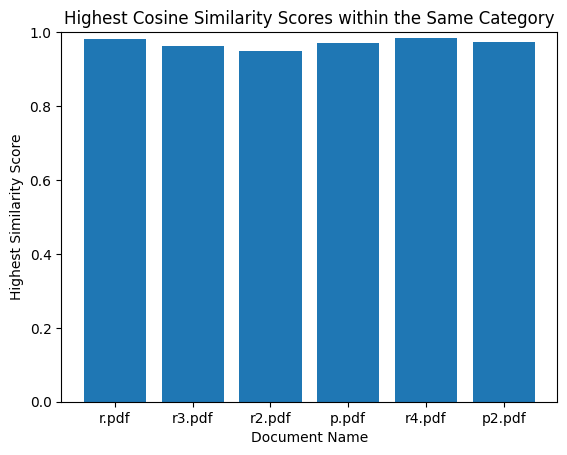

The highest similarity score of r.pdf within its category is: 98.08.
The highest similarity score of r3.pdf within its category is: 96.27.
The highest similarity score of r2.pdf within its category is: 95.01.
The highest similarity score of p.pdf within its category is: 97.08.
The highest similarity score of r4.pdf within its category is: 98.43.
The highest similarity score of p2.pdf within its category is: 97.46.


r.pdf: Risk Report
r3.pdf: Risk Report
r2.pdf: Risk Report
p.pdf: Privacy Policy
r4.pdf: Risk Report
p2.pdf: Privacy Policy


Analysis for Document 1:
The new document is most similar to risk14.pdf in terms of topics.
Topic 0: Could be improved. Current weight: 0.59, Reference weight: 0.67
Topic 1: Well covered. Current weight: 0.41, Reference weight: 0.33


Analysis for Document 2:
The new document is most similar to risk12.pdf in terms of topics.
Topic 0: Well covered. Current weight: 0.70, Reference weight: 0.67
Topic 1: Could be improved. Current weight: 0.30, Reference

In [6]:
# Plot the analyzed data

# Process new data for LDA topic analysis
new_X_count = count_vectorizer.transform(new_X_texts)  # BoW representation for new documents
new_X_topics = lda.transform(new_X_count)  # Topic distribution for new documents

# Calculate and plot the highest similarity scores
highest_scores = document_visualizer.calculate_similarity(new_X_combined, X_combined, y, predictions)
document_visualizer.plot_similarity(highest_scores, analyze_doc_names)

# Print out the highest similarity scores for each document
document_visualizer.print_highest_scores(highest_scores, analyze_doc_names)

print("\n")

# Print out predictions with document names
label_names = ["Risk Report", "Privacy Policy"]

for doc_name, label_index in zip(analyze_doc_names, predictions):
  print(f"{doc_name}: {label_names[label_index]}")

print("\n")

# Compare topics of new data with training data
document_visualizer.compare_topics(new_doc_topic_dist, doc_topic_dist, train_doc_names)

# Model Persistence
# Save the model
rf_clf.save_model('rf_model.pkl')

# Load the model (when needed)
# rf_clf.load_model('rf_model.pkl')

print("\nDone!")